# 2. Inference with COSDD

In this notebook, we load a trained model and use it to denoise the low signal-to-noise data.

In [1]:
import os
import logging
import math

import torch
import pytorch_lightning as pl
from pytorch_lightning.plugins.environments import LightningEnvironment
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tifffile

import utils
from models.lvae import LadderVAE
from models.pixelcnn import PixelCNN
from models.s_decoder import SDecoder
from models.unet import UNet
from models.hub import Hub

logger = logging.getLogger('pytorch_lightning')
logger.setLevel(logging.WARNING)
%matplotlib inline

In [2]:
assert torch.cuda.is_available()

### 2.1. Load test data
The images that we want to denoise are loaded here.

In [3]:
# Load data
low_snr = utils.load_data(paths="./data",
                          patterns="actin-confocal-lowsnr.tif",
                          axes="SYX",
                          n_dimensions=2)
print(f"Noisy data size: {low_snr.size()}")

Noisy data size: torch.Size([79, 1, 1024, 1024])


### Part 2. Create prediction dataloader

`predict_batch_size` (int): Number of denoised images to produce at a time.

In [4]:
predict_batch_size = 1

predict_set = utils.PredictDataset(low_snr)
predict_loader = torch.utils.data.DataLoader(
    predict_set,
    batch_size=predict_batch_size,
    shuffle=False,
    pin_memory=True,
)

### 2.3. Load trained model

In the cell below, we initialise all the model components again. It is important to use the same hyper-parameters that were used in training.ipynb.  Then, the parameters of the model trained in the previous notebook are loaded by setting `model_name`.

In [5]:
crop_size = (256, 256)

dimensions = 2
s_code_channels = 64

n_layers = 8
z_dims = [s_code_channels // 2] * n_layers
min_size = min(crop_size)
num_halves = math.floor(math.log2(min_size)) - 1
downsampling = [1] * n_layers
difference = max(n_layers - num_halves, 0)
i = 0
while difference > 0:
    for j in range(n_layers // 2):
        downsampling[i + j * 2] = 0
        difference -= 1
        if difference == 0:
            break
    i += 1
lvae = LadderVAE(
    colour_channels=low_snr.shape[1],
    img_size=crop_size,
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
    z_dims=z_dims,
    downsampling=downsampling,
    dimensions=dimensions,
)

ar_decoder = PixelCNN(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    kernel_size=5,
    noise_direction="x", 
    n_filters=64,
    n_layers=4,
    n_gaussians=5,
    dimensions=dimensions,
)

s_decoder = SDecoder(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
    dimensions=dimensions,
)

use_direct_denoiser = True
if use_direct_denoiser:
    direct_denoiser = UNet(
        colour_channels=low_snr.shape[1],
        n_filters=s_code_channels,
        n_layers=n_layers,
        downsampling=downsampling,
        loss_fn="MSE",
        dimensions=dimensions,
    )
else:
    direct_denoiser = None

In [6]:
model_name = "actin-confocal"
checkpoint_path = os.path.join("checkpoints", model_name)
hub = Hub.load_from_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt"),
                               vae=lvae, 
                               s_decoder=s_decoder,
                               ar_decoder=ar_decoder,
                               direct_denoiser=direct_denoiser)

predictor = pl.Trainer(
    accelerator="gpu",
    devices=1,
    enable_progress_bar=False,
    enable_checkpointing=False, 
    logger=False,
    precision="bf16-mixed",
    plugins=[LightningEnvironment()],
)

/home/ben/miniforge3/envs/dnm/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.4


### 2.4. Denoise
In this section, we will look at how COSDD does inference. <br>

The model denoises images randomly, giving us a different output each time. First, we will compare seven randomly sampled denoised images for the same noisy image. Then, we will produce a single consensus estimate by averaging 100 randomly sampled denoised images. Finally, if the direct denoiser was trained in the previous step, we will see how it can be used to estimate this average in a single pass.

### 2.4.1 Random sampling 
First, we will denoise each image seven times and look at the difference between each estimate. The output of the model is stored in the `samples` variable. This has dimensions [Number of images, Sample index, Channels, Z | Y | X] where different denoised samples for the same image are stored along sample index.

In [7]:
use_direct_denoiser = False
n_samples = 7

hub.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = predictor.predict(hub, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1).half()

100%|██████████| 7/7 [01:21<00:00, 11.59s/it]


Here, we'll look at the original noisy image and the seven denoised estimates. Change the value for `img_idx` to look at different images and change values for `top`, `bottom`, `left` and `right` to adjust the crop.

In [8]:
vmin = np.percentile(low_snr.numpy(), 1)
vmax = np.percentile(low_snr.numpy(), 99)

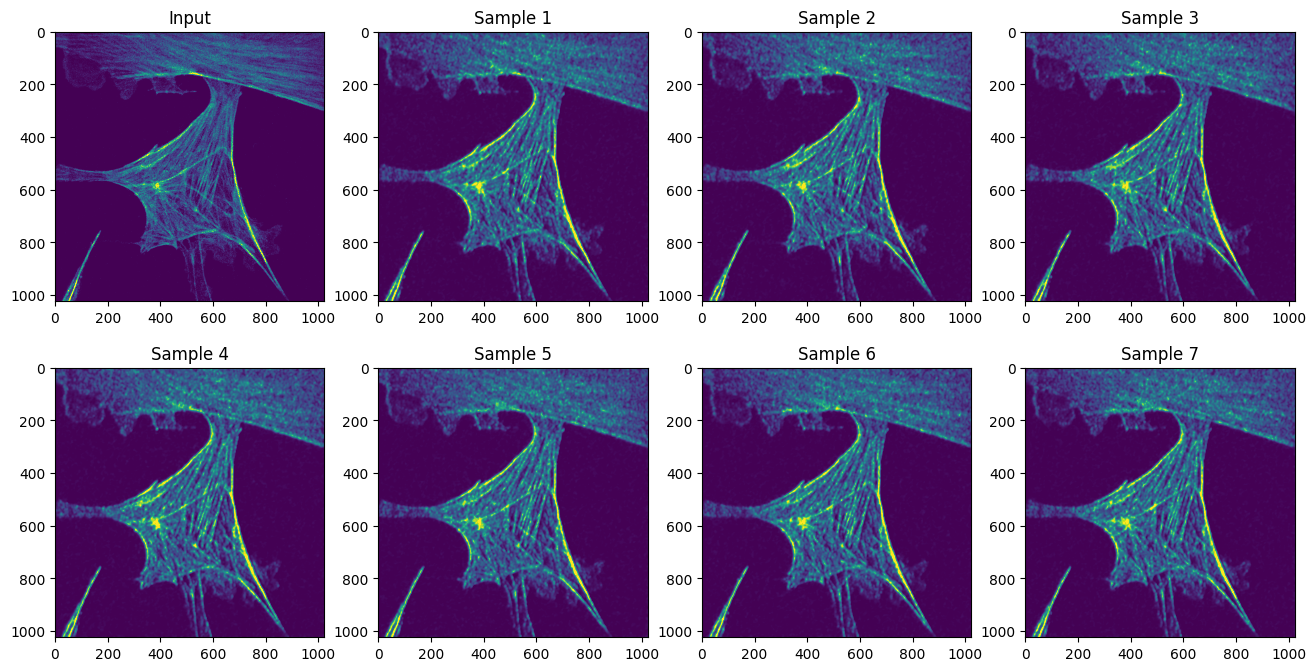

In [9]:
img_idx = 0
top = 0
bottom = 1024
left = 0
right = 1024

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0, 0].set_title("Input")
for i in range(n_samples):
    ax[(i + 1) // 4, (i + 1) % 4].imshow(
        samples[img_idx][i][crop], vmin=vmin, vmax=vmax
    )
    ax[(i + 1) // 4, (i + 1) % 4].set_title(f"Sample {i+1}")

plt.show()

The six sampled denoised images have subtle differences that express the uncertainty involved in this denoising problem.

### 2.4.2 MMSE estimate

In the next cell, we sample many denoised images and average them for the minimum mean square estimate (MMSE). The averaged images will be stored in the `MMSEs` variable, which has the same dimensions as `low_snr`. 

In [11]:
use_direct_denoiser = False
n_samples = 100

hub.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = predictor.predict(hub, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1).half()
MMSEs = torch.mean(samples, dim=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:04<00:00, 12.42s/it]


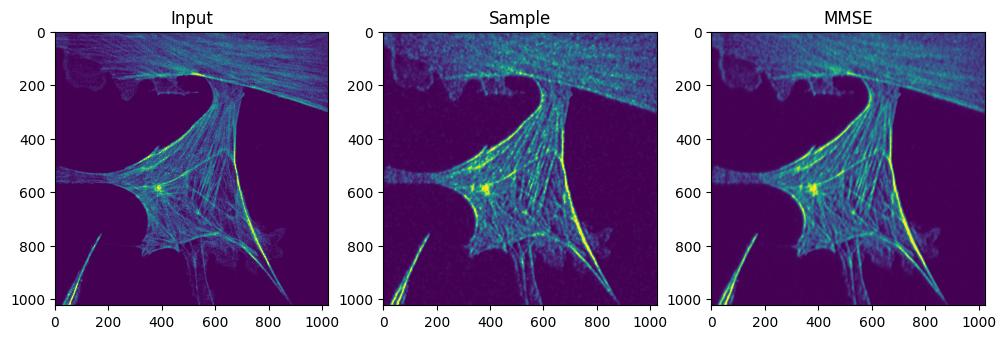

In [12]:
img_idx = 0
top = 0
bottom = 1024
left = 0
right = 1024

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(samples[img_idx][0][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Sample")
ax[2].imshow(MMSEs[img_idx][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")

plt.show()

### 2.4.3 Direct denoising
Sampling 100 images and averaging them is a very time consuming. If the direct denoiser was trained in a previous step, it can be used to directly output what the average denoised image would be for a given noisy image.

The following cell uses the direct denoiser for inference and saves the result to the `direct` variable.

In [13]:
use_direct_denoiser = True
hub.direct_pred = use_direct_denoiser

direct = predictor.predict(hub, predict_loader)
direct = torch.cat(direct, dim=0).half()

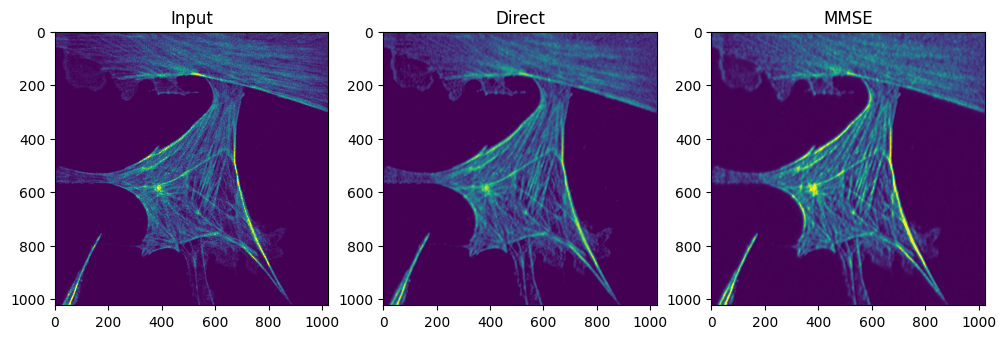

In [14]:
img_idx = 0
top = 0
bottom = 1024
left = 0
right = 1024

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(direct[img_idx][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Direct")
ax[2].imshow(MMSEs[img_idx][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")

plt.show()

In the following cell, choose a directory to save your results by setting `save_dir`.

Choose which images you want to save out of `direct`, `MMSEs` and\or `samples` by adding or removing them from the `to_save` list.

In [19]:
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

to_save = ["direct", "MMSEs", "samples"]
results = {"direct": direct,
           "MMSEs": MMSEs,
           "samples": samples}
for i in to_save:
    save_path = os.path.join(save_dir, i + ".tif")
    tifffile.imwrite(save_path, results[i].half().numpy())